# The Double-Wilson (DW) model with measurement error and resolution-dependence

## Introduction

The analysis in **notebook 2A** is not quite realistic for real data: 1) real data are noisy; and 2) the correlation between structure factor amplitudes of two related structures depends on resolution. Here we examine both aspects. 

Specifically,
- In the section **Synthetic data with measurement errors**, we repurpose the synthetic data generation from notebook 2A by adding randomly sampled error estimates from real experiments to synthetic data. 
- In the section **Correlations are resolution-dependent**, we introduce a model for the resolution dependence of correlation between datasets. This model was described by Randy Read in his 1990 paper "Structure-Factor Probabilities for Related Structures", and originally proposed by Luzzati in the context of structure refinement. This model is given by two parameters, $a, b$ and reasonably describes the resolution dependence of the double-Wilson parameter $r$. 
- In the subsection **Inferring _a_ and _b_ in the presence of measurement error**, we introduce a routine to estimate $a, b$ from noisy data. 

We see that the decline in correlation with resolution is not necessarily explained by the data just getting noisier--there can be a true resolution dependence of the correlation coefficient. 

**Notation**
- we will use $hkl$ and ```HKL```
- we will denote reciprocal lattice point coordinates as ```(rs_a,rs_b,rs_c)``` and $r*$, with magnitude $1/d_{hkl}$ or ```dHKL```. The scattering vector $s=S_1-S_0$ equals $r*$ in our case (elastic scattering).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import pandas  as pd
from tqdm      import tqdm
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':(5,3.5)})

In [2]:
import reciprocalspaceship as rs
import gemmi
from dw_tools       import modify_ds, wilson, plots, fitting_dw
from scipy.optimize import least_squares
from scipy.stats    import rice, foldnorm, vonmises, linregress, pearsonr

In [3]:
#%autosave 300
#%load_ext autoreload
#%autoreload 2
rs.__version__

'1.0.1'

# Synthetic data with measurement errors

## Read in reference data
We will generate synthetic data below. We will assign these synthetic data error estimates from a real reference set, which we read in here first.

In [4]:
path="double_wilson_data/"    # Unix
data_set_pairs = [("5kvx_phases", "5kw3_phases"),\
                  ("3pyp_phases", "1nwz_phases"),\
                  ("4kjk_phases", "4kjj_phases"),\
                  ("NECAT_PTP1B_RT_SAD/7rin_phases", "NECAT_PTP1B_RT_SAD/7mm1_phases")\
                 ]

example=0 #0,1,2 is good
mtz1 = data_set_pairs[example][0] # omit .mtz
mtz2 = data_set_pairs[example][1]
ds1 = rs.read_mtz(path + mtz1 + "_scaled.mtz")
ds2 = rs.read_mtz(path + mtz2 + "_scaled.mtz")

In [5]:
ds1_2= ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2.label_centrics(inplace=True)
if True:
    modify_ds.ds_high_res_cut(ds1_2, rescut=1.2, inplace=True)

EP1_label = "EP_1_aniso_2_1"
EP2_label = "EP_1_aniso_2_2"
dHKL_label= "dHKL_1"

### Distribution of amplitudes in the reference dataset
We begin by looking at how the normalized structure factors are distributed by percentile bin as a function of resolution. Sometimes we see that the central bins are _overrepresented_ at high resolution, where the effects of French-Wilson scaling are _very_ pronounced. Conversely, low-E values are _underrepresented_, presumably for the same reason. `sigma_cut` affords an opportunity to not include very noisy observations.

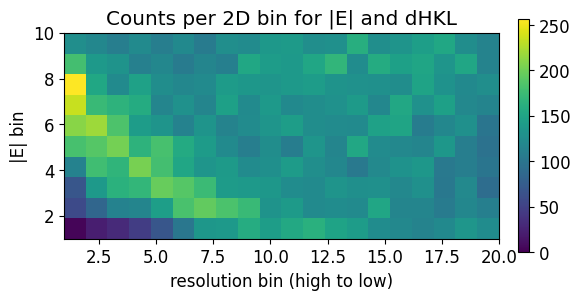

In [6]:
# Let's examine the distribution of dHKL and E in the real data
sig_cut = 2
nbin    = (20,10)
dHKL_bin_label="dHKL_bin"

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1_2["dHKL_1"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1_2["dHKL_1"], d_bins)
ds1_2[dHKL_bin_label] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1_2[EP1_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1_2[EP1_label], ep1_bins)
ds1_2["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(ds1_2.loc[(ds1_2["CENTRIC"]==False) & (ds1_2["SIG" + EP1_label]<sig_cut), dHKL_bin_label], \
                                   ds1_2.loc[(ds1_2["CENTRIC"]==False) & (ds1_2["SIG" + EP1_label]<sig_cut), "EP_1_bin"],bins=nbin)

plt.figure(figsize=(6,4))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)
plt.show()

Note that we define the bins before filtering the acentric |E| observations by SigF estimates. As a result, the average number of observations per amplitude bin can vary with resolution. In particular, the high-resolution bins often have the most noisy observations, and are depopulated. 

### Resampling experimental measurement errors
To our synthetic data, we will assign measurement errors sampled from actual data. We will sample per 2D bin defined in the previous subsection.

In [10]:
# resample experimental standard deviations
count_max = 10*np.max(H[:]).astype(int)
print(count_max)
sigE_samples = np.zeros([nbin[0],nbin[1],count_max])
replace = True    # sample with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

for i in range(nbin[0]):      # resolution
    for j in range(nbin[1]):  # E bin
        sigE_samples[i][j] = ds1_2.loc[(ds1_2[dHKL_bin_label]==i+1)&\
                                       (ds1_2["EP_1_bin"]==j+1),\
                                       "SIG" + EP1_label\
                                      ].sample(count_max,replace=replace).to_numpy()

2560


We initialize an array for fake data with experimental standard deviations and to-be-imposed covariance structure. 

In [11]:
ds1_2_fake=ds1_2[[dHKL_bin_label,"CENTRIC"]].copy()
ds1_2_fake[dHKL_label] = ds1_2[dHKL_label].copy()
ds1_2_fake.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 30126 entries, (0, 0, 40) to (36, 3, 3)
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dHKL_bin  30126 non-null  int64  
 1   CENTRIC   30126 non-null  bool   
 2   dHKL_1    30126 non-null  MTZReal
dtypes: MTZReal(1), bool(1), int64(1)
memory usage: 505.2 KB


We have now defined `ds_1_2_fake`, which will contain (below) a synthetic dataset with measurement errors sampled from actual data. 

# Correlations are resolution-dependent
The correlation coefficient for synthetic data with a single global correlation coefficient drops off more slowly than for the true data (see final plot). This seems to imply either/both of two things: 

1. Measurement errors are wildly overestimated at low resolution, and perhaps underestimated at high resolution, **and/or**
2. The correlation coefficient should really be considered resolution-dependent.

The latter is far more plausible. Indeed, R. Read, 1990 "Structure-Factor Probabilities for Related Structures" confirms this perspective and suggests a form $\rho=a e^{-b s^2}$. Based on that paper, **in case of isotropic, normally distributed coordinate shifts**, $b\sim \frac{2\pi^2}{3} \left< |\Delta r_j|^2\right>$. For example, $b=1$ corresponds to a root mean square coordinate shift (in 3D) of $\sqrt{\left< |\Delta r_j|^2\right>} =\frac{1}{\pi} \sqrt{3/2}$ = 0.4 A. More generally, the assumed rms coordinate shift is $0.39 \sqrt{b}$ in Angstrom. In this model, $a=1$.

### Creating synthetic data with resolution-dependent correlation and resampled experimental errors

#### Noise-less synthetic data
For a given _a_ and _b_, we create synthetic data without error. We will come up with a way to determine _a_ and _b_ from experimental data below.

In [12]:
acentric = (ds1_2_fake["CENTRIC"].to_numpy() == False)
centric  = (ds1_2_fake["CENTRIC"].to_numpy() == True )
count_by_bin_ac = ds1_2_fake.loc[acentric, dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).count().to_numpy()
res_means_ac    = ds1_2_fake.loc[acentric, dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).mean( ).to_numpy()
count_by_bin_c  = ds1_2_fake.loc[centric,  dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).count().to_numpy()
res_means_c     = ds1_2_fake.loc[centric,  dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).mean( ).to_numpy()
# print(count_by_bin_ac)
# print(count_by_bin_c)

# see further down for an explanation:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)

mean    = [0,0,0,0]            # mean of random walks
ds1_2_fake["EP_2"] = np.zeros(ds1_2_fake.shape[0])
ds1_2_fake["EP_1"] = np.zeros(ds1_2_fake.shape[0])
for i in range(nbin[0]):       # loop over resolution bins
    # let's generate acentric pairs (the assignments to parts of columns create warnings)
    r  = a*np.exp(-b/(res_means_ac[i]**2))
    cov= 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=count_by_bin_ac[i])
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & acentric, "EP_1"] = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 )
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & acentric, "EP_2"] = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 )
    
    # now for centric pairs
    r = a*np.exp(-b/(res_means_c[i]**2))
    cov           = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=count_by_bin_c[i])
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & centric,"EP_1"] = np.sqrt(2*E_1x_1y_2x_2y[:,0]**2)
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & centric,"EP_2"] = np.sqrt(2*E_1x_1y_2x_2y[:,2]**2)


`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.8022e+00, final cost 2.2206e-03, first-order optimality 1.20e-07.


#### Generating corresponding synthetic data with errors
Let's generate the bins of fake observations for which we will resample errors from the reference dataset's observed errors.

In [13]:
ep1_fake_bins = rice.ppf(np.linspace(0,0.999,nbin[1]+1),0,0,np.sqrt(0.5))
ep1_fake_bins[-1] = 100
ep2_fake_bins = rice.ppf(np.linspace(0,0.999,nbin[1]+1),0,0,np.sqrt(0.5))
ep2_fake_bins[-1] = 100

ep1_fake_dig  = np.digitize(ds1_2_fake["EP_1"], ep1_fake_bins)
ep2_fake_dig  = np.digitize(ds1_2_fake["EP_2"], ep2_fake_bins)
# print(plt.hist(ep2_fake_dig)) # these bins are not great for fake data

We now generate noisy versions of the true EP1, EP2 generated above. These will be our EP1_obs, EP2_obs with known associated errors.

In [14]:
# Construct an array of fake measurements with the same EP1 and dHKL bins as the data
# we're assuming that the same error distribution applies to normalized centric and acentric structure factors.
S = ds1_2_fake.shape[0]
ep1_fake_obs    = np.zeros((S,))
sig_ep1_fake_obs= np.zeros((S,))
count_array     = np.zeros(nbin).astype(int)
for i in tqdm(range(S)):
    i_E    = ep1_fake_dig[i] - 1
    i_dHKL = ds1_2_fake.iloc[i][dHKL_bin_label] - 1
    i_dHKL = i_dHKL.astype(int)                       
    sigma  = sigE_samples[i_dHKL][i_E][count_array[i_dHKL][i_E]]
    loc    = ds1_2_fake.iloc[i]["EP_1"]
    count_array[i_dHKL][i_E] += 1
    ep1_fake_obs[i]           = np.random.normal(loc=loc,scale=sigma)
    sig_ep1_fake_obs[i]       = sigma
    
ds1_2_fake["EP_1_obs"   ] = ep1_fake_obs
ds1_2_fake["SIGEP_1_obs"] = sig_ep1_fake_obs

# same for the other one, we continue counting in the counting array
# i.e. uncorrelated errors (errors may well be correlated in reality!)
ep2_fake_obs= np.zeros((S,))
sig_ep2_fake_obs= np.zeros((S,))
for i in tqdm(range(S)):
    i_E    = ep2_fake_dig[i] - 1
    i_dHKL = ds1_2_fake.iloc[i][dHKL_bin_label] - 1
    i_dHKL = i_dHKL.astype(int)                       # for some reason, the last one or two are corrupted
    sigma  = sigE_samples[i_dHKL][i_E][count_array[i_dHKL][i_E]]
    loc    = ds1_2_fake.iloc[i]["EP_2"]
    count_array[i_dHKL][i_E] += 1
    ep2_fake_obs[i]           = np.random.normal(loc=loc,scale=sigma)
    sig_ep2_fake_obs[i]       = sigma
    
ds1_2_fake["EP_2_obs"]=ep2_fake_obs
ds1_2_fake["SIGEP_2_obs"]=sig_ep2_fake_obs

100%|██████████| 30126/30126 [00:03<00:00, 9787.51it/s]


Let's plot these "observed" (i.e. with measurement error) fake data. Because we generate fake observed data by sampling from a normal distribution around the fake true data, the fake observed data can be slightly negative.

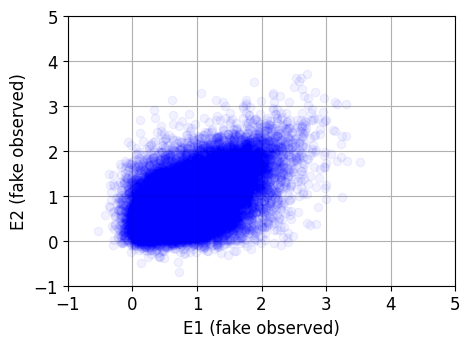

In [15]:
plt.plot(ds1_2_fake["EP_1_obs"].to_numpy(), ds1_2_fake["EP_2_obs"].to_numpy(),'bo',alpha=0.05)
# plt.plot(ds1_2_fake["EP_1_obs"].to_numpy(), ds1_2_fake["EP_2_obs"].to_numpy(),'ro',alpha=0.002)
plt.xlabel("E1 (fake observed)")
plt.ylabel("E2 (fake observed)")
plt.xlim([-1,5])
plt.ylim([-1,5])
plt.grid(); plt.show()

## Expected correlation between related datasets, with and without measurement error

The next step is to relate the expected correlation coefficient under the double-Wilson model to the expected correlation coefficient when we add in measurement error. The underlying model is as follows: For each $hkl$, we'll consider that for the first model, the true structure factor amplitudes are $EP1_{true}=x$ and $EP2_{true}=x+\epsilon$. That is, $\epsilon$ captures fixed effects. Instead, we observe $EP1_{obs}=x+\eta_1$ and $EP2_{obs}=x+\epsilon + \eta_2$ with $\eta_1$ and $\eta_2$ the measurement errors. It does not matter whether the errors are truely additive--these relationships can be considered to define $\eta_1$ and $\eta_2$. We will assume that the reported errors are accurate estimates of the standard deviations of  $\eta_1$ and $\eta_2$. 

Then,

$\rho_{obs} = \rho(x+\eta_1,x+\epsilon+\eta_2)=\frac{\sigma_x^2}{\sqrt{\left(\sigma_x^2 + \sigma_1^2 \right)                  
                                                                       \left(\sigma_x^2 + \sigma_\epsilon^2
                                                                                        + \sigma_2^2\right)}
                                                                       }$ 
and 
$\rho_{true}= \rho(x,x+\epsilon)=\frac{\sigma_x^2}{\sqrt{\sigma_x^2 \left(\sigma_x^2+\sigma_\epsilon^2\right)}}$

where we've used that all covariances between $x,\epsilon,\eta_1,\eta_2$ are 0 (except "self-covariance") and abbreviated error std's as $\sigma_1$ and $\sigma_2$. Some algebra yields:

$\rho_{obs}^{-2} = \rho_{true}^{-2} + \frac{\sigma^2_1+\sigma^2_2}{\sigma^2_x} + \frac{\sigma^2_1 \sigma^2_2}{\sigma^4_x} + \frac{\sigma^2_1}{\sigma^2_x}\left(\rho_{true}^{-2}-1 \right)$

Since it is arbitrary to assign the fixed effects to dataset 2 rather than dataset 1, we symmetrize the last term below to $\frac{\sigma_1\sigma_2}{\sigma^2_x}\left(\rho_{true}^{-2}-1 \right)$.

Note that $\sigma^2_x$ is, in our model, the variance of the Wilson distribution for normalized structure factors. This variance differs between centric and acentric Wilson distributions. For simplicity, we use below estimates obtained above by sampling. Because the estimated $\rho_{obs}$ depends on error estimates of structure factor amplitudes, we estimate it below *for each observed normalized structure factor*.

#### Inferring _a_ and _b_ in the presence of measurement error

So far, we've assumed some *a and b*. We'll now put all the calculations above together into a fitting routine (see ```fitting_dw.py```). For simplicity, we approximate the correlation between error-less normalized structure factor amplitudes under the model as $\rho=r^2$ as shown in notebook 2a. Let's compare the data to our double-Wilson model with resolution-dependent $r$, either using the sampling procedure described first, or the (almost) analytical fitting procedure in ```fitting_dw.py```.

In [16]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print("a: " + str(a))
print("b: " + str(b))

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.8022e+00, final cost 2.2206e-03, first-order optimality 1.20e-07.
a: 0.9790681398078425
b: 1.0899677914019943


#### Calculating expected correlations under the mutlivariate model with and without measurement error
The correlations between synthetic observed datasets will be lower than those between the synthetic true datasets. Using the calculations above, we can relate the two, again using that $\rho(|E_1|,|E_2|)\approx r^2$.

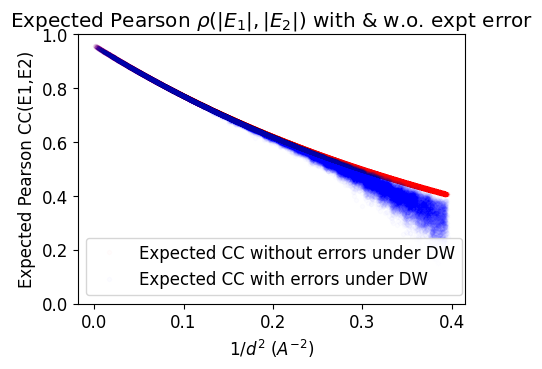

In [17]:
d          = ds1_2_fake[dHKL_label].to_numpy()

r_by_res   = a*np.exp(-b/(d**2))                  # DW r
r_by_res   = r_by_res.flatten()
rho_no_err = r_by_res**2        # we use that almost rho=r**2
rho_no_err = rho_no_err.flatten()

varW_acentric= rice.var(0,0,np.sqrt(0.5))
varW_centric = foldnorm.var(0,0,1)
tmp1         = ds1_2_fake["SIGEP_1_obs"].to_numpy()**2 # 
tmp2         = ds1_2_fake["SIGEP_2_obs"].to_numpy()**2 # 
quad_var_E   = tmp1+tmp2

rho_w_err_inv2_ac = (1/rho_no_err**2) + quad_var_E/varW_acentric +\
                   tmp1*tmp2/varW_acentric**2 + ((1/rho_no_err**2)-1)*np.sqrt(tmp1*tmp2)/varW_acentric
rho_w_err_inv2_c  = (1/rho_no_err**2) + quad_var_E/varW_centric +\
                   tmp1*tmp2/varW_centric**2  + ((1/rho_no_err**2)-1)*np.sqrt(tmp1*tmp2)/varW_centric

rho_w_err_ac = 1/np.sqrt(rho_w_err_inv2_ac) #(rho_no_err**2/(1+rho_no_err**2  + (tmp**2)/(varW_acentric)))
rho_w_err_c  = 1/np.sqrt(rho_w_err_inv2_c)  #(rho_no_err**2/(1+rho_no_err**2  + (tmp**2)/(varW_acentric)))

ds1_2_fake["Exp rho w error"]=np.nan
ds1_2_fake.loc[acentric,"Exp rho w error"] = rho_w_err_ac[acentric]
ds1_2_fake.loc[centric, "Exp rho w error"] = rho_w_err_c[  centric]

plt.plot(1/d**2, rho_no_err, 'r.',  label="Expected CC without errors under DW", alpha=0.01)
plt.plot(1/d**2, rho_w_err_ac, 'b.',label="Expected CC with errors under DW",    alpha=0.01)
plt.title(r"Expected Pearson $\rho(|E_1|,|E_2|)$ with & w.o. expt error")
plt.xlabel(r"$1/d^2$ ($A^{-2}$)")
plt.ylabel("Expected Pearson CC(E1,E2)")
plt.legend()
plt.ylim((0,1))
plt.show()

It is also informative to plot the correlation coefficients in the presence and absence of measurement errors against each other.

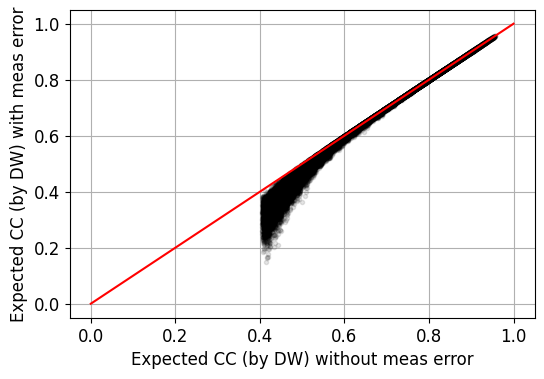

In [18]:
plt.figure(figsize=(6,4))
plt.plot(rho_no_err, rho_w_err_ac, 'k.',alpha=0.1)
plt.grid()
plt.plot([0,1],[0,1],'r-')
plt.xlabel("Expected CC (by DW) without meas error")
plt.ylabel("Expected CC (by DW) with meas error")
plt.show()

# plt.figure(figsize=(6,4))
# plt.title("distr. of expected CC with meas error")
# plt.ylabel("Count")
# plt.hist(rho_w_err_ac,100)
# plt.show()

For each resolution bin,  we can now calculate an average expected correlation coefficient, weighting by measurement error.

In [19]:
ds=ds1_2_fake # view for brevity
rho_avg=np.zeros((20,1))
for i in range(ds[dHKL_bin_label].min(),ds[dHKL_bin_label].max()+1):
    boi = (ds[dHKL_bin_label]==i) # bin of interest
    rho = ds.loc[boi,"Exp rho w error"].to_numpy()
    w   = 1/(ds.loc[boi,"SIGEP_1_obs"]*ds["SIGEP_2_obs"][boi]).to_numpy()
    w = w + np.percentile(w,5)
    tmp = np.sum(w*rho)/np.sum(w)
    rho_avg[i-1] = np.sum(w*rho)/np.sum(w) # np.mean(rho) gives nearly the same results

Let's compare our correlation coefficients.

Average observations per bin: 1506.3
Average observations per bin: 1506.3
Average observations per bin: 1506.3


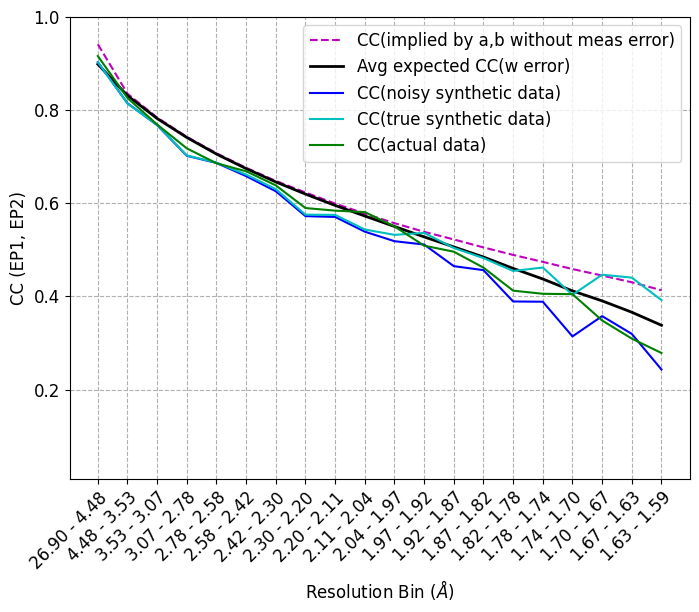

In [20]:
result_1, labels_1 = plots.compute_cc(ds1_2_fake,labels=["EP_1_obs","EP_2_obs"],nbins=20,method="pearson")
result_2, labels_2 = plots.compute_cc(ds1_2_fake,labels=["EP_1",    "EP_2"],    nbins=20,method="pearson")
result_3, labels_3 = plots.compute_cc(ds1_2,     labels=[EP1_label,  EP2_label],nbins=20,method="pearson")

res_range = np.zeros([20,1])
for i in range(len(labels_1)):
    tmp1 = float(labels_1[i].split()[0])
    tmp3 = float(labels_1[i].split()[2])
    tmp2 = np.sqrt(tmp1*tmp3) # geom mean
    res_range[i] = tmp2
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(20), ((a*np.exp(-b/(res_range**2)))**2).flatten(),'m--',label="correlation implied by (a,b) without meas error") # this is correct for acentrics
plt.plot(np.flip(np.arange(20)), rho_avg, 'k-',linewidth=2)
plots.plot_by_res_bin(result_1, labels_1)
plots.plot_by_res_bin(result_2, labels_2,color='c')
plots.plot_by_res_bin(result_3, labels_3,color='g')
plt.legend(["CC(implied by a,b without meas error)", "Avg expected CC(w error)", "CC(noisy synthetic data)", "CC(true synthetic data)", "CC(actual data)"])
ylim=plt.ylim()
plt.ylim([np.amax([0,ylim[0]-0.2]),np.amin([1,ylim[1]+0.2])])
plt.ylabel("CC (EP1, EP2)")
plt.show()

We see that the resolution dependence of the correlation coefficient in this data set is explained mostly by the true differences in structures (magenta), with small contributions from experimental error (cf. black v magenta and blue v cyan). Note that the noisy synthetic data in effect incorporates measurement error twice.